<a href="https://colab.research.google.com/github/mkorob/DementiaDataSynthEval/blob/main/Alzheimer's_Feature_Construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Generation

## 0. Preliminaries

In [2]:
!pip install nltk

In [3]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [4]:
import pandas as pd

In [7]:
import re

## 1. Load Data

In [59]:
df = pd.read_csv("/content/dementia_diaries_final_utf8.csv")

In [60]:
df_control = pd.read_csv("/content/Control_transcripts - Sheet1 (1).csv")

## 2. Pre-process Data

In [61]:
def clean_transcript(text):

    # Remove newlines and replace with spaces
    text = text.replace('\n', ' ')

    # Remove timestamps in the format (hh:mm) or hh:mm
    text = re.sub(r'\(\d{1,2}:\d{2}\)', '', text)  # Removes (hh:mm)
    text = re.sub(r'\b\d{1,2}:\d{2}\b', '', text)  # Removes hh:mm

    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()

    #clean transcript cues
    # Remove text inside square brackets
    text = re.sub(r'\[.*?\]', '', text)
    # Remove newlines
    text = text.replace('\n', ' ')
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [62]:
#pre-processing raw transcript data from timestamps
df_control = df_control.dropna(subset = "Text")
df_control['text_cleaned'] = df_control['Text'].apply(clean_transcript)

In [63]:
df = df.dropna(subset = "text")
df['text_cleaned'] = df['text'].apply(clean_transcript)

In [64]:
df_control.head()

,SpeakerID,Text,Date,Group,Unnamed: 4,text_cleaned
0,1,"What’s up? What’s up? What’s up, everybody? We...",NaN,Control,921.0,"What’s up? What’s up? What’s up, everybody? We..."
1,1,"What’s up? What’s up? What’s up, everybody? We...",NaN,Control,957.0,"What’s up? What’s up? What’s up, everybody? We..."
2,1,"What’s up? What’s up? What’s up, everybody? We...",NaN,Control,1033.0,"What’s up? What’s up? What’s up, everybody? We..."
3,1,"What’s up? What’s up? What’s up, everybody? We...",NaN,Control,1033.0,"What’s up? What’s up? What’s up, everybody? We..."
4,1,"What’s up, everybody? Welcome back to THE a.m ...",NaN,Control,947.0,"What’s up, everybody? Welcome back to THE a.m ..."


## 3. Feature Generation

In [65]:
def first_snippet_select(filtered_sentences):
    processed_text = ""
    word_count = 0
    #remove first sentence
    for sentence in filtered_sentences:
        words = nltk.word_tokenize(sentence)
        if word_count + len(words) <= 200:
            processed_text += sentence + " "
            word_count += len(words)
        else:
            remaining_words = 200 - word_count
            processed_text += " ".join(words[:remaining_words])
            break

    return processed_text

In [66]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

In [67]:
import numpy as np
from collections import Counter
import string

word_count_snippet = 200

def calculate_features(text):

  words = nltk.word_tokenize(text)
  sentences = nltk.sent_tokenize(text)

  # Remove punctuation from words
  sentence_words = [word for word in words if word not in string.punctuation]

  if len(words) >= 200:
    # Remove sentences with less than three words
      filtered_sentences = [sentence for sentence in sentences if len(tokenizer.tokenize(sentence)) >= 4]
      filtered_text = first_snippet_select(filtered_sentences)
      filtered_words = nltk.word_tokenize(filtered_text)


      # Tag parts of speech
      pos_tags = nltk.pos_tag(filtered_words)

      def determiner_noun_phrase_ratio(pos_tags):
          determiners = sum(1 for word, pos in pos_tags if pos == 'DT')
          noun_phrases = sum(1 for word, pos in pos_tags if pos in ['NN', 'NNS', 'NNP', 'NNPS'])
          return determiners / noun_phrases if noun_phrases > 0 else 0

      def word_count(words):
          return len(words)

      def vp_np_ratio(pos_tags):
          verb_phrases = sum(1 for word, pos in pos_tags if pos.startswith('VB'))
          noun_phrases = sum(1 for word, pos in pos_tags if pos in ['NN', 'NNS', 'NNP', 'NNPS'])
          return verb_phrases / noun_phrases if noun_phrases > 0 else 0

      def coordinate_phrases_ratio(pos_tags):
          coordinate_conjunctions = sum(1 for word, pos in pos_tags if pos == 'CC')
          phrases = sum(1 for word, pos in pos_tags if pos in ['NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'])
          return coordinate_conjunctions / phrases if phrases > 0 else 0

      def subordinate_ratio(pos_tags):
          subordinate_conjunctions = sum(1 for word, pos in pos_tags if pos in ['IN', 'RP'])
          coordinate_conjunctions = sum(1 for word, pos in pos_tags if pos == 'CC')
          return subordinate_conjunctions / coordinate_conjunctions if coordinate_conjunctions > 0 else 0

      def avg_word_length(words):
          return np.mean([len(word) for word in words])

      def proportion_subjects(pos_tags):
          subjects = sum(1 for word, pos in pos_tags if pos in ['NN', 'NNS', 'NNP', 'NNPS'])
          return subjects / len(words) if len(words) > 0 else 0

      # Calculate the features
      features = {
          'filtered_words': " ".join(filtered_words),
          'determiner_noun_phrase_ratio': determiner_noun_phrase_ratio(pos_tags),
          'word_count_snip': word_count(filtered_words),
          'vp_np_ratio': vp_np_ratio(pos_tags),
          'coordinate_phrases_ratio': coordinate_phrases_ratio(pos_tags),
          'subordinate_ratio': subordinate_ratio(pos_tags),
          'avg_word_length': avg_word_length(filtered_words),
          'proportion_subjects': proportion_subjects(pos_tags),
      }

      return features

  return

In [68]:
# Apply the function to create new columns in the DataFrame
features_df = df['text'].apply(lambda x: pd.Series(calculate_features(x)))

# Concatenate the original DataFrame with the new features DataFrame
df = pd.concat([df[['author_ID', 'text']], features_df], axis=1)

In [69]:
# Apply the function to create new columns in the DataFrame
features_df_control = df_control['text_cleaned'].apply(lambda x: pd.Series(calculate_features(x)))

In [70]:
# Concatenate the original DataFrame with the new features DataFrame
df_control = pd.concat([df_control, features_df_control], axis=1)

In [71]:
df.head()

,author_ID,text,filtered_words,determiner_noun_phrase_ratio,word_count_snip,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects
0,1,Good morning everybody itâ€™s Agnes from Coatb...,Good morning everybody itâ€™s Agnes from Coatb...,0.265306,200.0,0.816327,0.089888,2.125000,4.100,0.161716
1,1,"Good morning everybody, itâ€™s Agnes from Coat...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,"Good morning everybody, itâ€™s Agnes from Coat...","Good morning everybody , itâ€™s Agnes from Coa...",0.480000,200.0,1.880000,0.138889,2.900000,4.105,0.112108
3,1,Good morning everybody. Itâ€™s the weekend. I ...,Itâ€™s the weekend . I believe itâ€™s Saturday...,0.431818,200.0,0.681818,0.121622,1.666667,3.845,0.146667
4,1,Hi everyone. Itâ€™s Agnes from Coatbridge cal...,Itâ€™s Agnes from Coatbridge calling and I wan...,0.451613,200.0,1.096774,0.261538,0.647059,4.110,0.096573


In [72]:
#remove empty rows
df = df.dropna(subset="filtered_words")
df_control = df_control.dropna(subset="filtered_words")

In [73]:
df.groupby('author_ID').count()

,text,filtered_words,determiner_noun_phrase_ratio,word_count_snip,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects
author_ID,,,,,,,,,
1,23,23,23,23,23,23,23,23,23
2,9,9,9,9,9,9,9,9,9
3,19,19,19,19,19,19,19,19,19
4,3,3,3,3,3,3,3,3,3
5,14,14,14,14,14,14,14,14,14
6,21,21,21,21,21,21,21,21,21
7,3,3,3,3,3,3,3,3,3
8,14,14,14,14,14,14,14,14,14
9,12,12,12,12,12,12,12,12,12


In [74]:
df_control.groupby('SpeakerID').count()

,Text,Date,Group,Unnamed: 4,text_cleaned,filtered_words,determiner_noun_phrase_ratio,word_count_snip,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects
SpeakerID,,,,,,,,,,,,,
1,20,0,20,20,20,20,20,20,20,20,20,20,20
2,20,0,0,0,20,20,20,20,20,20,20,20,20
3,10,0,0,0,10,10,10,10,10,10,10,10,10
4,20,0,0,0,20,20,20,20,20,20,20,20,20
5,15,0,0,0,15,15,15,15,15,15,15,15,15
6,20,0,0,0,20,20,20,20,20,20,20,20,20


Select authors with enough rows

In [75]:
df_select_authors = df[df['author_ID'].isin([1, 3, 6, 10, 11])]

In [76]:
df_control_select_authors = df_control[df_control['SpeakerID'].isin([1, 2, 4, 5, 6])]

## 4. Feature Inspection

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

In [78]:
features = ['determiner_noun_phrase_ratio', 'word_count_snip', 'vp_np_ratio', 'coordinate_phrases_ratio', 'subordinate_ratio', 'avg_word_length','proportion_subjects']

In [79]:
df_control[['SpeakerID']+features].groupby('SpeakerID').mean()

,determiner_noun_phrase_ratio,word_count_snip,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects
SpeakerID,,,,,,,
1,0.275937,200.00,0.912723,0.106742,2.563495,3.585500,0.032147
2,0.367717,200.00,0.759338,0.062452,5.963534,4.011000,0.056063
3,0.372891,200.00,1.066309,0.061512,6.072619,3.728000,0.072009
4,0.351796,200.05,0.599374,0.077650,3.768810,4.093760,0.156304
5,0.378362,200.00,0.927006,0.135121,2.320888,4.049333,0.070372
6,0.488838,199.90,1.754235,0.121890,2.227074,3.779107,0.032678


In [80]:
df_select_authors[['author_ID']+features].groupby('author_ID').mean()

,determiner_noun_phrase_ratio,word_count_snip,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects
author_ID,,,,,,,
1,0.340444,199.826087,0.924698,0.129625,1.897111,3.996473,0.138240
3,0.329257,200.000000,0.947681,0.138681,2.289820,3.858421,0.079116
6,0.374889,200.000000,0.827089,0.121152,2.656085,3.832381,0.167652
10,0.378888,200.000000,0.881409,0.159227,1.805527,3.890000,0.114793
11,0.374106,200.000000,1.038308,0.099621,3.009003,3.351750,0.122569


In [81]:
df_control_select_authors[['SpeakerID']+features].groupby('SpeakerID').std()

,determiner_noun_phrase_ratio,word_count_snip,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects
SpeakerID,,,,,,,
1,0.069420,0.000000,0.230230,0.030834,1.025494,0.156288,0.004129
2,0.090198,0.000000,0.223794,0.032481,3.621414,0.222602,0.017260
4,0.080946,0.223607,0.148616,0.025731,1.420155,0.277815,0.036318
5,0.088957,0.000000,0.228487,0.038284,0.927473,0.396416,0.027545
6,0.220156,0.307794,0.671382,0.028347,0.612638,0.286236,0.013920


In [82]:
df_select_authors[['author_ID']+features].groupby('author_ID').std()

,determiner_noun_phrase_ratio,word_count_snip,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects
author_ID,,,,,,,
1,0.112105,0.834058,0.293924,0.037041,0.593709,0.176130,0.042084
3,0.103853,0.000000,0.222942,0.051764,0.830534,0.198711,0.021849
6,0.086603,0.000000,0.265826,0.047684,1.070055,0.167620,0.036698
10,0.092516,0.000000,0.227408,0.055555,0.691298,0.216704,0.052953
11,0.074351,0.000000,0.394251,0.040403,1.529953,0.192909,0.029816


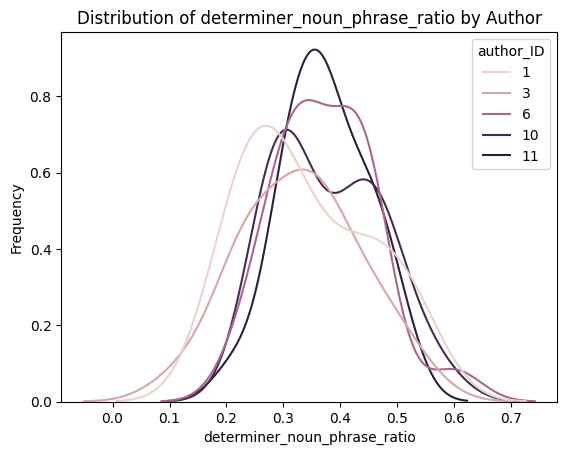

<ipython-input-83-7c0fe4329ae8>:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_select_authors, x=feature, hue='author_ID')


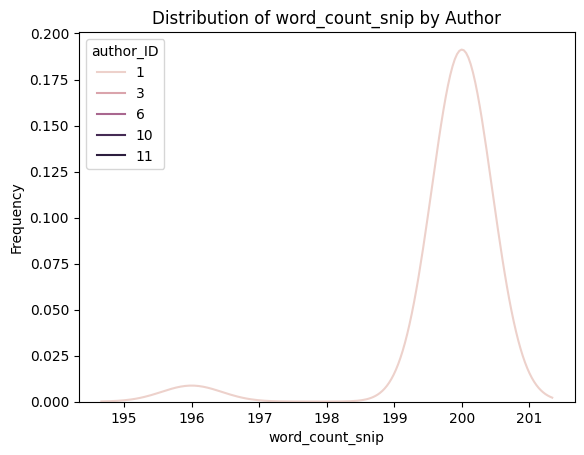

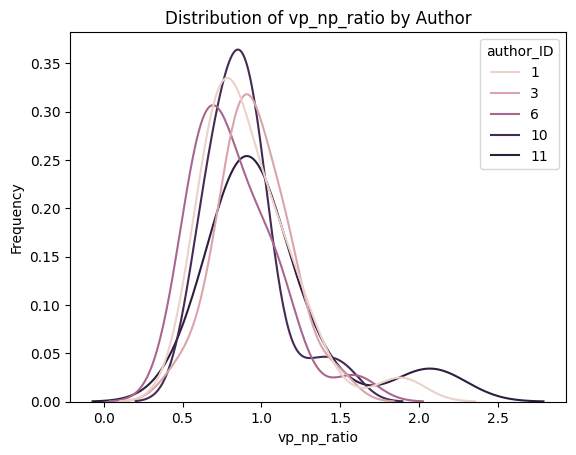

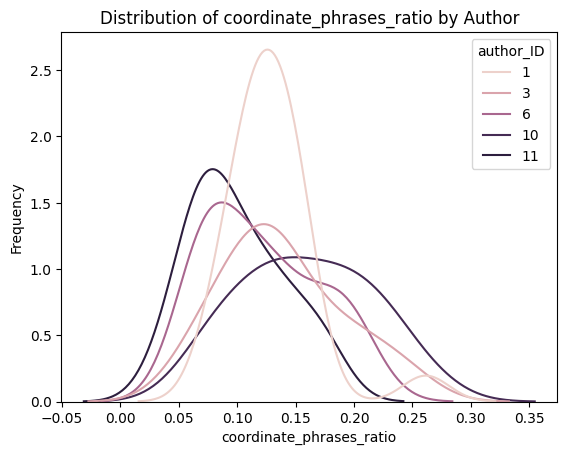

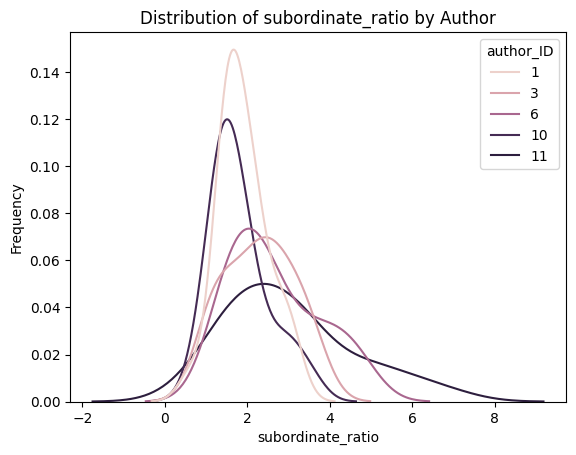

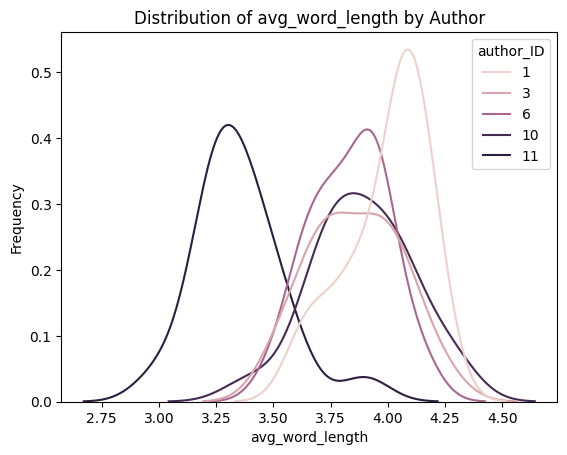

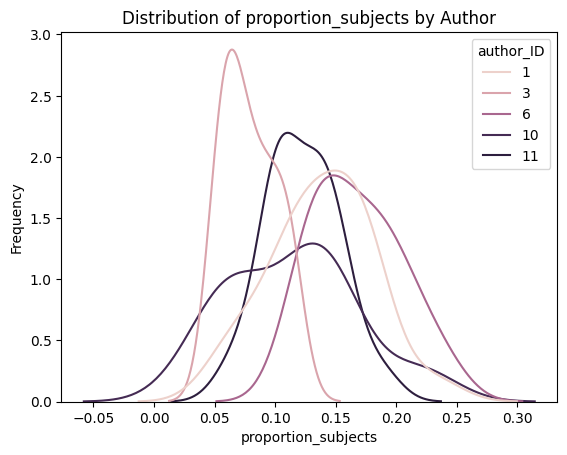

In [83]:
# Plotting the distribution of features for each author
features = [feature for feature in features if feature != "word_count"]
for feature in features:
    sns.kdeplot(data=df_select_authors, x=feature, hue='author_ID')
    plt.title(f'Distribution of {feature} by Author')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

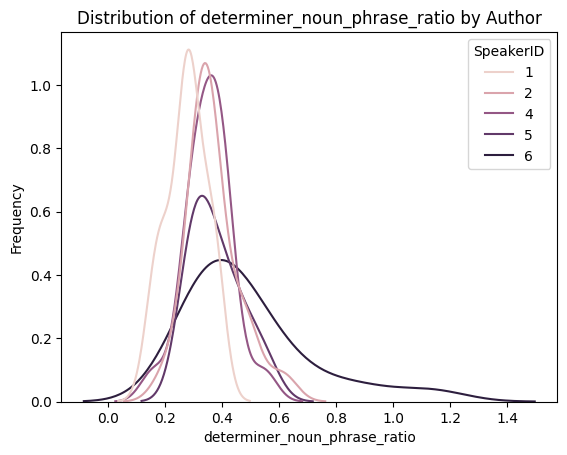

<ipython-input-84-61d38581a88e>:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_control_select_authors, x=feature, hue='SpeakerID')


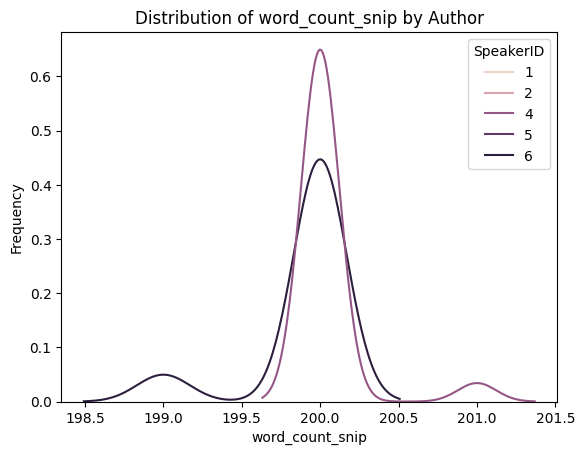

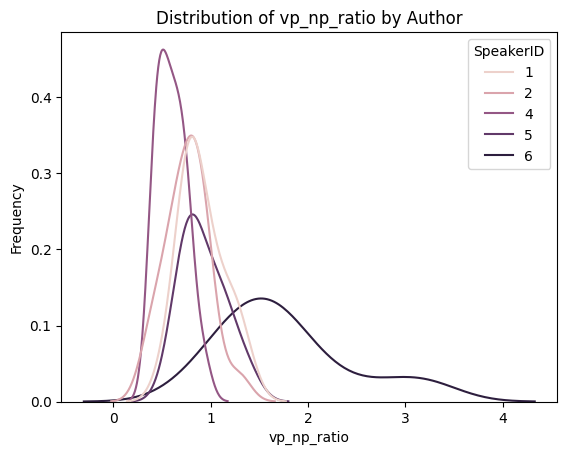

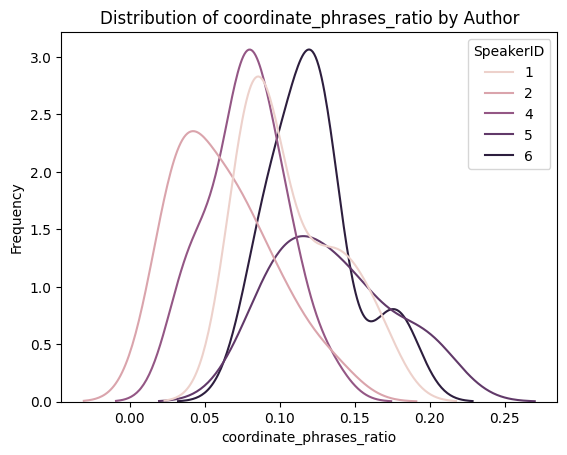

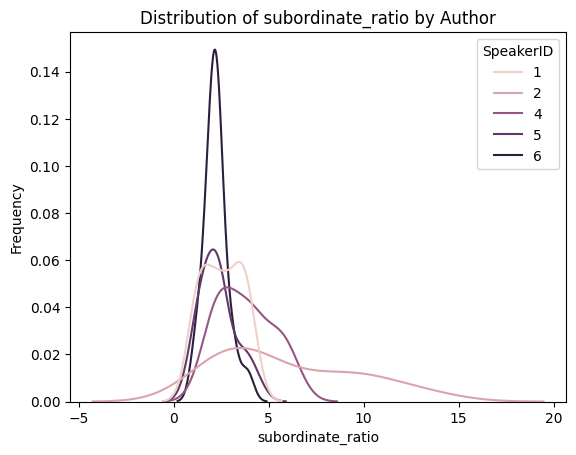

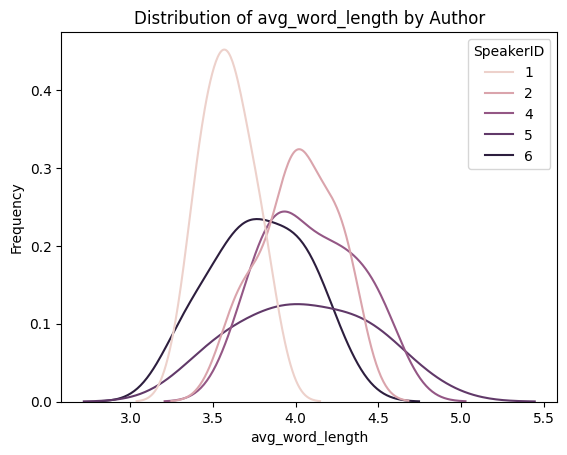

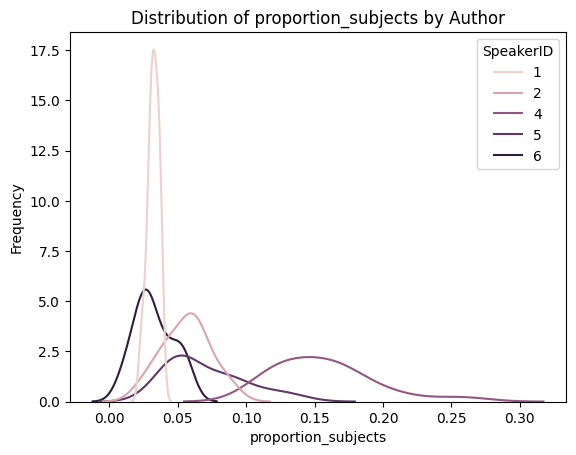

In [84]:
# Plotting the distribution of features for each author

for feature in features:
    sns.kdeplot(data=df_control_select_authors, x=feature, hue='SpeakerID')
    plt.title(f'Distribution of {feature} by Author')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

In [85]:
import scipy
scipy.stats.ttest_ind(df_select_authors.loc[df_select_authors['author_ID'] == 1, 'vp_np_ratio'], df_select_authors.loc[df_select_authors['author_ID'] == 6, 'vp_np_ratio'], equal_var=False)

TtestResult(statistic=1.156695615228124, pvalue=0.25393392070599596, df=41.997744552704695)

In [86]:
import numpy as np
import scipy.stats

def f_test(group1, group2):
   print(np.var(group1))
   print(np.var(group2))
   f = np.var(group1, ddof=1)/np.var(group2, ddof=1)
   nun = group1.size-1
   dun = group2.size-1
   p_value = 1-scipy.stats.f.cdf(f, nun, dun)
   return f, p_value

# perform F-test
f_test(df_select_authors.loc[df_select_authors['author_ID'] == 1, 'coordinate_phrases_ratio'], df_select_authors.loc[df_select_authors['author_ID'] == 10, 'coordinate_phrases_ratio'])

0.0013123678640229635
0.0029320248267252617


(0.4445459975076296, 0.965056763298661)

## 5. Merge and Save

In [91]:
df_select_authors['group'] = "dem"
df_select_authors['ID'] = df_select_authors['author_ID'].astype(str) + df_select_authors['group']
df_control_select_authors['group'] = "control"
df_control_select_authors['ID'] = df_control_select_authors['SpeakerID'].astype(str) + df_control_select_authors['group']
df_final = pd.concat([df_select_authors[['ID', 'group'] + features], df_control_select_authors[['ID', 'group'] + features]]).dropna().reset_index(drop = True)

<ipython-input-91-3f08140b4574>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select_authors['group'] = "dem"
<ipython-input-91-3f08140b4574>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select_authors['ID'] = df_select_authors['author_ID'].astype(str) + df_select_authors['group']
<ipython-input-91-3f08140b4574>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [92]:
df_final.groupby('ID').count()

,group,determiner_noun_phrase_ratio,word_count_snip,vp_np_ratio,coordinate_phrases_ratio,subordinate_ratio,avg_word_length,proportion_subjects
ID,,,,,,,,
10dem,20,20,20,20,20,20,20,20
11dem,20,20,20,20,20,20,20,20
1control,20,20,20,20,20,20,20,20
1dem,23,23,23,23,23,23,23,23
2control,20,20,20,20,20,20,20,20
3dem,19,19,19,19,19,19,19,19
4control,20,20,20,20,20,20,20,20
5control,15,15,15,15,15,15,15,15
6control,20,20,20,20,20,20,20,20


In [93]:
df_final.to_csv("final_data_texts_w_features.csv")